In [33]:
%load_ext autoreload
%autoreload 2

import torch
# from PolySym import Regressor, Operators
from polysym.torch_operators import Operators
from polysym.regressor import Configurator
from polysym.model import PolySymModel
from polysym.evaluation import r2
from polysym.utils import compile_tree

n_obs = 1000

X3d = torch.zeros((n_obs, 2, 100))
X2d = torch.zeros((n_obs, 1))
y1d = torch.zeros(n_obs)
y2d = torch.zeros(n_obs, 100)

for obs in range(n_obs):

    start, end = torch.rand(2) * 100

    x1 = torch.linspace(start, end, 100)
    x2 = torch.cos(torch.linspace(start, end, 100))
    b = torch.randint(low=-10, high=10, size=(1, 1))

    y = (b + x1 + (x1 * x2))
    # expr=binary_add(binary_add(x0, n0), binary_mul(v1, v0))

    expr = 'binary_add(binary_add(x0, v0), binary_mul(v0, v1))'

    X3d[obs, 0] = x1
    X3d[obs, 1] = x2
    X2d[obs] = b
    y1d[obs] = torch.mean(y).item()
    y2d[obs] = y

operators = Operators(['add', 'sub', 'mul', 'div', 'neg', 'mean'])

model = PolySymModel(X3d=X3d,
                        X2d=X2d,
                        y=y2d,
                        operators=operators,
                        min_complexity=4,
                        max_complexity=6,
                        scale=False,
                        pop_size=300,
                        stopping_criterion=.99,
                        max_iter=50,
                        fitness_fn = r2,
                        fitness_obj = 1,
                        seed=42,
                        verbose=1,
                        optimize_ephemerals=False,
                        workers=-1)

#print(model.eval_expr(expr))

# TODO: fix scaling

with torch.no_grad():
    f = compile_tree(expr, model.pset)            # or compile_tree
    pred = f(*model.inputs)

print("max |y-ŷ| =", (pred - y2d).abs().max())
print("R² manual =", 1 - ((pred - y2d)**2).sum() /
                     ((y2d - y2d.mean())**2).sum())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
max |y-ŷ| = tensor(0.)
R² manual = tensor(1.)


In [34]:
import os, torch, multiprocessing as mp

"""# ---- put this at the top of your main script ----
for var in ("OMP_NUM_THREADS","MKL_NUM_THREADS","OPENBLAS_NUM_THREADS"):
    os.environ[var] = "1"
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

if mp.get_start_method(allow_none=True) != "fork":
    mp.set_start_method("fork", force=True)"""   # Linux, CPU‑only
# -----------------------------------------------

model.fit()

2025-04-26 12:37:27,680 - INFO - Running iteration 0/50; best fit=-inf
2025-04-26 12:37:35,843 - INFO - Running iteration 10/50; best fit=0.96
2025-04-26 12:37:40,161 - INFO - Running iteration 20/50; best fit=0.96
2025-04-26 12:37:45,059 - INFO - Running iteration 30/50; best fit=0.96
2025-04-26 12:37:49,878 - INFO - Running iteration 40/50; best fit=0.96
2025-04-26 12:37:55,315 - INFO - Finished iterating, wrapping up fitting...
2025-04-26 12:37:55,317 - INFO - Overall best depth=2 fitness=0.98 ; expr=binary_add(binary_mul(v0, v1), binary_add(v0, x0))


In [35]:
model.summary()

Best depth=2 fitness=0.98 ; expr=binary_add(binary_mul(v0, v1), binary_add(v0, x0))
Depth=1 fitness=0.28 ; expr=binary_add(v1, v0)
Depth=2 fitness=0.98 ; expr=binary_add(binary_mul(v0, v1), binary_add(v0, x0))
Depth=3 fitness=0.80 ; expr=binary_add(binary_mul(v0, v1), unary_mean(binary_sub(v0, -13.144761935838758)))
Depth=4 fitness=0.94 ; expr=unary_neg(unary_neg(binary_sub(binary_mul(v0, v1), unary_neg(v0))))
Depth=5 fitness=0.95 ; expr=binary_add(binary_add(v0, unary_neg(binary_mul(binary_mul(93.57419001376292, v0), binary_div(v1, -93.78358954137533)))), binary_add(x0, binary_mul(binary_div(binary_div(v1, 4.027256586417096), binary_mul(93.57419001376292, v0)), v0)))
Depth=6 fitness=0.94 ; expr=binary_add(binary_add(binary_sub(unary_neg(binary_mul(v1, binary_div(v1, -93.78358954137533))), unary_neg(v0)), unary_neg(binary_mul(binary_mul(93.57419001376292, v0), binary_div(v1, -93.78358954137533)))), binary_add(x0, binary_mul(binary_div(binary_div(v1, 4.027256586417096), unary_mean(v0)),

In [36]:
model.eval_expr('binary_add(binary_add(x0, v0), binary_mul(v0, v1))')

1.0

In [199]:
import sympy as sp

ind = model.best_per_depth[3][2]
expr = sp.sympify('binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))')

print(expr)
print(sp.simplify(expr))

binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))
binary_add(binary_mul(unary_neg(-14), binary_mul(v0, v1)), binary_mul(unary_neg(v0), -14))


In [11]:
for i in list(model.pset.terminals.values())[0]:
    print(i.name)

print(type(model.pset.terminals))
print(model.pset.terminals)

x0
v0
v1
randc
<class 'collections.defaultdict'>
defaultdict(<class 'list'>, {<class 'object'>: [<deap.gp.Terminal object at 0x139e49440>, <deap.gp.Terminal object at 0x139e4a600>, <deap.gp.Terminal object at 0x139e4aec0>, <class 'deap.gp.randc'>]})


In [169]:
print(model.best_expr)

binary_add(binary_add(x0, v0), binary_mul(v0, v1))


In [30]:
model.depth_quota

{4: np.int64(100), 5: np.int64(100), 6: np.int64(100)}

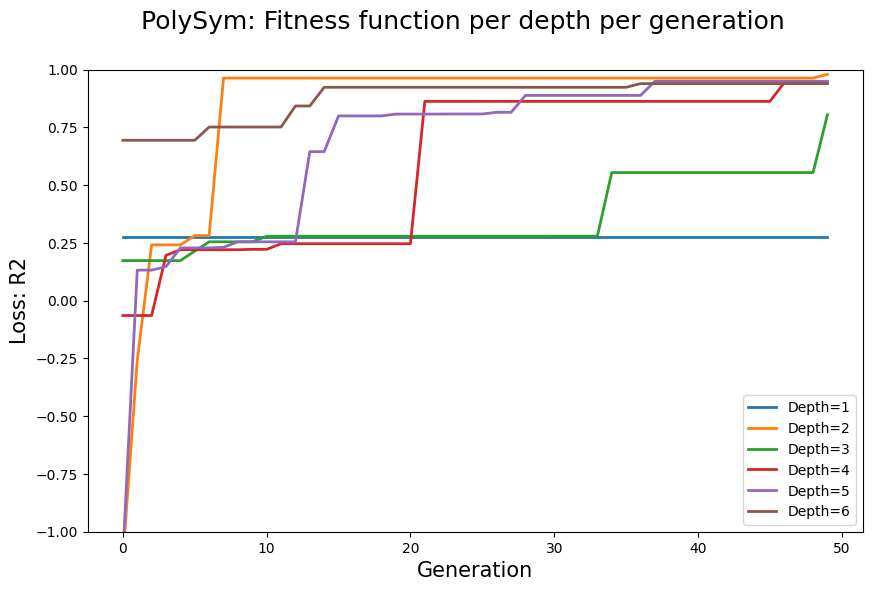

In [37]:
model.plot_differential_loss()

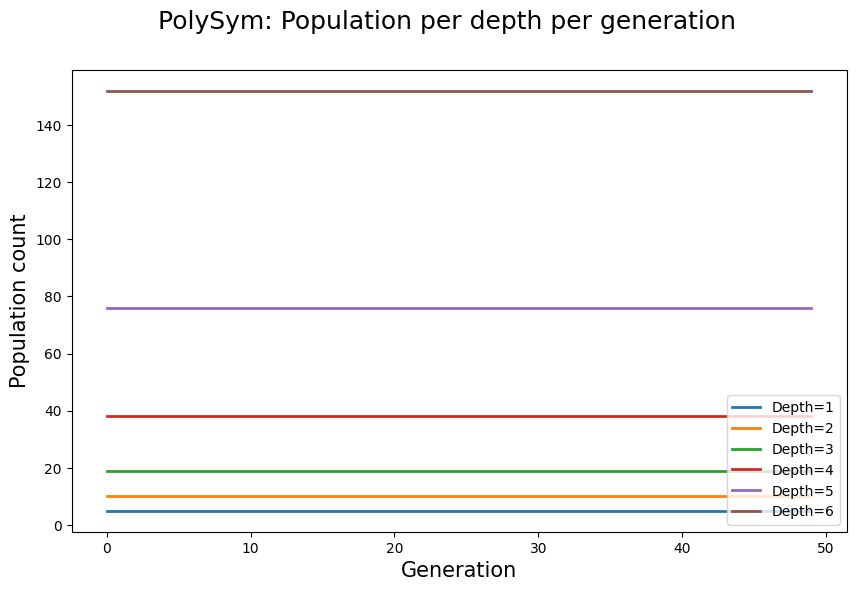

In [38]:
model.plot_depth_per_gen()

In [227]:
from polysym.eval_rank import is_valid_tree

depth = 5
operators = Operators(['add', 'sub', 'mul', 'div', 'neg', 'mean'])
model = PolySymModel(X3d=X3d,
                        X2d=X2d,
                        y=y1d,
                        operators=operators,
                        min_complexity=5,
                        max_complexity=depth,
                        scale=False,
                        pop_size=300,
                        stopping_criterion=.99,
                        max_iter=20,
                        fitness_fn = r2,
                        fitness_obj = 1,
                        seed=42,
                        verbose=1,
                        workers=-1)

pop = model.toolbox.population(n=100)
heights_constraint = [i.height != depth for i in pop]
dim_mismatches = [model.toolbox.evaluate(i)[1] for i in pop]
are_valids = [is_valid_tree(ind, 1) for ind in pop]
any(heights_constraint), any(dim_mismatches), sum(dim_mismatches), sum(are_valids)

(False, False, 0, 100)